In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import pickle
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import simps
from scipy.optimize import minimize
import emcee
import corner
from lal import C_SI

/tmp/ipykernel_247241/1511788918.py:13: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import C_SI


In [2]:
def dipole_cal(g, ra, dec, l=264, b=48):
    dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    dipole_ICRS = dipole_gal.transform_to('icrs')

    phi_dipole = dipole_ICRS.ra.value*np.pi/180
    theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

    nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
    ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
    nz_dipole = np.cos(theta_dipole)

    phi = ra
    theta = np.pi/2-np.array(dec)

    nx = np.cos(phi)*np.sin(theta)
    ny = np.sin(phi)*np.sin(theta)
    nz = np.cos(theta)

    dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

    return dipole

from scipy.integrate import cumtrapz
from scipy.optimize import fmin
from scipy.interpolate import interp1d, UnivariateSpline

class confidence_interval(object):
    def __init__(self, posterior, param, level=0.683, verbose=False):
        self.posterior = posterior
        self.param = param
        self.level = level
        self.verbose = verbose
        self.lower_level, self.upper_level = self.HDI()
        self.interval = self.upper_level - self.lower_level
        self.map = self.MAP()
        
    def HDI(self):
        cdfvals = cumtrapz(self.posterior, self.param)
        sel = cdfvals > 0.
        x = self.param[1:][sel]
        cdfvals = cdfvals[sel]
        ppf = interp1d(cdfvals, x, fill_value=0., bounds_error=False)

        def intervalWidth(lowTailPr):
            ret = ppf(self.level + lowTailPr) - ppf(lowTailPr)
            if (ret > 0.):
                return ret
            else:
                return 1e4
        HDI_lowTailPr = fmin(intervalWidth, 1. - self.level, disp=self.verbose)[0]
        return ppf(HDI_lowTailPr), ppf(HDI_lowTailPr + self.level)

    def MAP(self):
        sp = UnivariateSpline(self.param, self.posterior, s=0.)
        x_highres = np.linspace(self.param[0], self.param[-1], 100000)
        y_highres = sp(x_highres)
        return x_highres[np.argmax(y_highres)]


In [3]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/BBH/GW_injections_XG.p", "rb")
XG_BBH_inj = pickle.load(fr)
fr.close()

In [4]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/NSBH/GW_injections_XG.p", "rb")
XG_NSBH_inj = pickle.load(fr)
fr.close()

In [5]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/BNS/GW_injections_XG.p", "rb")
XG_BNS_inj = pickle.load(fr)
fr.close()

In [6]:
dl_0_BBH = XG_BBH_inj['injections_parameters']['dls']
dl_0_NSBH = XG_NSBH_inj['injections_parameters']['dls']
dl_0_BNS = XG_BNS_inj['injections_parameters']['dls']

In [7]:
index_BBH = []
index_NSBH = []
index_BNS = []
for i in range(len(dl_0_BBH)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p005/BBH_cov_{i}.txt')
        if len(XG_BBH_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_BBH[i]<461:
            index_BBH.append(i)
    except:
        continue

for i in range(len(dl_0_NSBH)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p005/NSBH_cov_{i}.txt')
        if len(XG_NSBH_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_NSBH[i]<461:
            index_NSBH.append(i)
    except:
        continue

for i in range(len(dl_0_BNS)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p005/BNS_cov_{i}.txt')
        if len(XG_BNS_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_BNS[i]<461:
            index_BNS.append(i)
    except:
        continue


In [8]:
len(index_BBH),len(index_NSBH),len(index_BNS)

(33, 3, 3)

In [9]:
index_BBH

[1,
 2,
 3,
 7,
 8,
 9,
 14,
 15,
 16,
 17,
 18,
 21,
 22,
 24,
 27,
 28,
 29,
 30,
 32,
 33,
 36,
 37,
 39,
 42,
 43,
 44,
 46,
 48,
 50,
 51,
 53,
 54,
 57]

In [10]:
index_NSBH

[6, 23, 39]

In [11]:
index_BNS

[1, 40, 44]

In [12]:
# samples = [0]*(len(index_BBH)+len(index_NSBH)+len(index_BNS))
# for i,ind in enumerate(index_BBH):
#     samples[i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p005/BBH_Fisher_samples_{ind}.dat', names=True)
# for i,ind in enumerate(index_NSBH):
#     samples[len(index_BBH)+i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p005/NSBH_Fisher_samples_{ind}.dat', names=True)
# for i,ind in enumerate(index_BNS):
#     samples[len(index_BBH)+len(index_NSBH)+i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p005/BNS_Fisher_samples_{ind}.dat', names=True)


In [13]:
index_all = np.append(np.append(np.array(index_BBH),np.array(index_NSBH)),np.array(index_BNS))

In [14]:
# fig = plt.figure(figsize=(26,25))
# gs = gridspec.GridSpec(10, 8, wspace=0.1)

# for i in range(0,10):
#     for j in range(0,8):

#         if 8*i+j >= len(index_BBH)+len(index_NSBH)+len(index_BNS):
#             break

#         ax = plt.subplot(gs[8*i+j])
#         plt.title('event %d'%index_all[8*i+j])

#         plt.hist(samples[8*i+j]['ra']/np.pi*180,bins=50,histtype='step')

#         plt.axvline(np.mean(samples[8*i+j]['ra']/np.pi*180),color='k',linestyle='--',alpha=0.6)

#         if j==0:
#             ax.set_ylabel('likelihood',fontsize=15)

#         ax.set_yticklabels([])
#         # plt.xlim(10,200)
#         plt.ylim(bottom=0)

In [15]:
# fig = plt.figure(figsize=(26,25))
# gs = gridspec.GridSpec(10, 8, wspace=0.1)

# for i in range(0,10):
#     for j in range(0,8):

#         if 8*i+j >= len(index_BBH)+len(index_NSBH)+len(index_BNS):
#             break

#         ax = plt.subplot(gs[8*i+j])
#         plt.title('event %d'%index_all[8*i+j])

#         plt.hist(samples[8*i+j]['dec']/np.pi*180,bins=50,histtype='step')

#         plt.axvline(np.mean(samples[8*i+j]['dec']/np.pi*180),color='k',linestyle='--',alpha=0.6)

#         if j==0:
#             ax.set_ylabel('likelihood',fontsize=15)

#         ax.set_yticklabels([])
#         # plt.xlim(10,200)
#         plt.ylim(bottom=0)

In [16]:
# ra_std = [0]*len(index_all)
# dec_std = [0]*len(index_all)
# ra_mean = [0]*len(index_all)
# dec_mean = [0]*len(index_all)
# for i in range(len(index_all)):
#     ra_std[i] = np.std(samples[i]['ra'])
#     dec_std[i] = np.std(samples[i]['dec'])
#     ra_mean[i] = np.mean(samples[i]['ra'])
#     dec_mean[i] = np.mean(samples[i]['dec'])

In [17]:
zs = [0]*len(index_all)
ra_mean = [0]*len(index_all)
dec_mean = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    zs[i] = XG_BBH_inj['injections_parameters']['zs'][ind]
    ra_mean[i] = XG_BBH_inj['injections_parameters']['ras'][ind]
    dec_mean[i] = XG_BBH_inj['injections_parameters']['decs'][ind]
for i,ind in enumerate(index_NSBH):
    zs[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['zs'][ind]
    ra_mean[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['ras'][ind]
    dec_mean[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['decs'][ind]
for i,ind in enumerate(index_BNS):
    zs[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['zs'][ind]
    ra_mean[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['ras'][ind]
    dec_mean[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['decs'][ind]

In [18]:
g=0.005

z0 = [0]*len(index_all)
for i,ind in enumerate(index_BBH):
    z0[i] = (1+zs[i]) * (1+dipole_cal(g, XG_BBH_inj['injections_parameters']['ras'][ind], XG_BBH_inj['injections_parameters']['decs'][ind])) -1
for i,ind in enumerate(index_NSBH):
    z0[len(index_BBH)+i] = (1+zs[len(index_BBH)+i]) * (1+dipole_cal(g, XG_NSBH_inj['injections_parameters']['ras'][ind], XG_NSBH_inj['injections_parameters']['decs'][ind])) -1
for i,ind in enumerate(index_BNS):
    z0[len(index_BBH)+len(index_NSBH)+i] = (1+zs[len(index_BBH)+len(index_NSBH)+i]) * (1+dipole_cal(g, XG_BNS_inj['injections_parameters']['ras'][ind], XG_BNS_inj['injections_parameters']['decs'][ind])) -1

In [19]:
ra_std = [0]*len(index_all)
dec_std = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p005/BBH_cov_{ind}.txt')
    ra_std[i] = np.sqrt(data[4,4])
    dec_std[i] = np.sqrt(data[5,5])
for i,ind in enumerate(index_NSBH):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p005/NSBH_cov_{ind}.txt')
    ra_std[len(index_BBH)+i] = np.sqrt(data[4,4])
    dec_std[len(index_BBH)+i] = np.sqrt(data[5,5])
for i,ind in enumerate(index_BNS):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p005/BNS_cov_{ind}.txt')
    ra_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[4,4])
    dec_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[5,5])    

In [20]:
np.array(ra_std)/np.pi*180

array([0.04300001, 0.02014596, 0.09837064, 0.01266553, 0.02242631,
       0.03519547, 0.0194717 , 0.02037128, 0.02873443, 0.03312225,
       0.01938817, 0.0342024 , 0.0433854 , 0.04877607, 0.04778608,
       0.09894878, 0.03156538, 0.06642238, 0.01867067, 0.01806538,
       0.01222241, 0.0168333 , 0.03382005, 0.01429935, 0.03263477,
       0.07772412, 0.02246248, 0.05035194, 0.00477507, 0.04044194,
       0.03879069, 0.02807652, 0.06134119, 0.03825063, 0.05369232,
       0.06892316, 0.07052059, 0.01928961, 0.08490466])

In [21]:
np.array(dec_std)/np.pi*180

array([0.00734295, 0.15037085, 0.03426647, 0.04321748, 0.02032041,
       0.01190455, 0.02568051, 0.0145127 , 0.02809372, 0.00629722,
       0.01989507, 0.05561095, 0.07617512, 0.04154325, 0.04941442,
       0.01890054, 0.02254669, 0.01906166, 0.01868746, 0.03814726,
       0.15787317, 0.03029237, 0.03422815, 0.01965354, 0.03106475,
       0.01763676, 0.01181562, 0.05882028, 0.00373643, 0.01145424,
       0.02668875, 0.0069847 , 0.01379353, 0.0467795 , 0.04136376,
       0.04208753, 0.05068325, 0.09904758, 0.03491571])

In [22]:
np.array(ra_std)/np.pi*180*np.array(dec_std)/np.pi*180

array([3.15747077e-04, 3.02936507e-03, 3.37081455e-03, 5.47372352e-04,
       4.55711774e-04, 4.18986203e-04, 5.00043135e-04, 2.95642259e-04,
       8.07257057e-04, 2.08578156e-04, 3.85729094e-04, 1.90202798e-03,
       3.30488782e-03, 2.02631635e-03, 2.36132121e-03, 1.87018550e-03,
       7.11695001e-04, 1.26612077e-03, 3.48907261e-04, 6.89144671e-04,
       1.92959109e-03, 5.09920619e-04, 1.15759764e-03, 2.81032938e-04,
       1.01379100e-03, 1.37080162e-03, 2.65408092e-04, 2.96171500e-03,
       1.78416906e-05, 4.63231783e-04, 1.03527505e-03, 1.96106018e-04,
       8.46111256e-04, 1.78934567e-03, 2.22091631e-03, 2.90080532e-03,
       3.57421242e-03, 1.91058934e-03, 2.96450662e-03])

In [23]:
dl_mean = [0]*len(index_all)
dl_std = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    dl_mean[i] = dl_0_BBH[ind] * (1+dipole_cal(g, XG_BBH_inj['injections_parameters']['ras'][ind], XG_BBH_inj['injections_parameters']['decs'][ind]))
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p005/BBH_cov_{ind}.txt')
    dl_std[i] = np.sqrt(data[2,2])
for i,ind in enumerate(index_NSBH):
    dl_mean[len(index_BBH)+i] = dl_0_NSBH[ind] * (1+dipole_cal(g, XG_NSBH_inj['injections_parameters']['ras'][ind], XG_NSBH_inj['injections_parameters']['decs'][ind]))
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p005/NSBH_cov_{ind}.txt')
    dl_std[len(index_BBH)+i] = np.sqrt(data[2,2])
for i,ind in enumerate(index_BNS):
    dl_mean[len(index_BBH)+len(index_NSBH)+i] = dl_0_BNS[ind] * (1+dipole_cal(g, XG_BNS_inj['injections_parameters']['ras'][ind], XG_BNS_inj['injections_parameters']['decs'][ind])) 
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p005/BNS_cov_{ind}.txt')
    dl_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[2,2])
 
    # dl_mean[i] = np.mean(samples[i]['luminosity_distance'])
    # dl_std[i] = np.std(samples[i]['luminosity_distance'])

In [32]:
def chi2_dl_dipole(glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, H0=70, Om0=0.3):
    g = glb[0]
    l = glb[1]
    b = glb[2]
    
    dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    dipole_ICRS = dipole_gal.transform_to('icrs')

    phi_dipole = dipole_ICRS.ra.value*np.pi/180
    theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

    nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
    ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
    nz_dipole = np.cos(theta_dipole)

    chi2 = 0

    for i in range(len(ra_arr)):
        phi = ra_arr[i]
        theta = np.pi/2-np.array(dec_arr[i])

        nx = np.cos(phi)*np.sin(theta)
        ny = np.sin(phi)*np.sin(theta)
        nz = np.cos(theta)

        dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

        astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
        zt = (1+zs_arr[i])/(1+dipole) -1
        dl_0 = astropy_cosmology.luminosity_distance(zt).value
        dl_g = dl_0*(1+dipole)

        chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2

    return chi2


In [33]:
chi2_dl_dipole([1.250e-04, 268, 48], ra_mean, dec_mean, z0, dl_mean, dl_std, H0=70, Om0=0.3)

15796.204235632047

In [34]:
minimize(chi2_dl_dipole, [0,268,48], args=(ra_mean, dec_mean, z0, dl_mean, dl_std), method='Nelder-Mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5.4341731856816226e-09
             x: [ 5.000e-03  2.640e+02  4.800e+01]
           nit: 91
          nfev: 165
 final_simplex: (array([[ 5.000e-03,  2.640e+02,  4.800e+01],
                       [ 5.000e-03,  2.640e+02,  4.800e+01],
                       [ 5.000e-03,  2.640e+02,  4.800e+01],
                       [ 5.000e-03,  2.640e+02,  4.800e+01]]), array([ 5.434e-09,  1.798e-08,  2.255e-08,  2.324e-08]))

In [35]:
# cov_index = [0]*len(index)
# for i,ind in enumerate(index):
#     cov_data = np.loadtxt(f'covariance_XG_snr500/cov_{ind}.txt')
#     cov_index[i] = np.zeros((3,3))
#     cov_index[i][0,0] = cov_data[2,2]
#     cov_index[i][0,1:] = cov_data[2,4:]
#     cov_index[i][1:,0] = cov_data[4:,2]
#     cov_index[i][1:,1:] = cov_data[4:,4:]

In [36]:
def logprob_dl_g(glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, H0=70, Om0=0.3):
    g = glb[0]
    l = glb[1]
    b = glb[2]

    if 0<=g<1 and 0<=l<=360 and -90<=b<=90:

        dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
        dipole_ICRS = dipole_gal.transform_to('icrs')

        phi_dipole = dipole_ICRS.ra.value*np.pi/180
        theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

        nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
        ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
        nz_dipole = np.cos(theta_dipole)

        chi2 = 0

        for i in range(len(ra_arr)):
            phi = ra_arr[i]
            theta = np.pi/2-np.array(dec_arr[i])

            nx = np.cos(phi)*np.sin(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(theta)

            dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

            astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
            zt = (1+zs_arr[i])/(1+dipole) -1
            dl_0 = astropy_cosmology.luminosity_distance(zt).value
            dl_g = dl_0*(1+dipole)

            # x = np.array([dl_g, ra_arr[i], dec_arr[i]])
            # mu = np.array([dl_mean[i], ra_arr[i], dec_arr[i]])
            # diff = x - mu
            
            # chi2 += np.dot(diff, np.linalg.solve(cov_matrix, diff))
            chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2
        
        logprob = -0.5*chi2

    else:
        logprob = -np.inf

    return logprob


In [37]:
nwalkers = 32
ndim = 3
p0 = np.random.rand(nwalkers, ndim)*np.array([1,360,180]) - np.array([0,0,90])
print(p0)

[[ 8.76553652e-01  8.47966709e+00  7.91087629e+01]
 [ 3.41977323e-01  1.42139676e+02 -3.40507934e+01]
 [ 3.05543683e-01  1.73125279e+02  8.16143037e+01]
 [ 6.42610510e-01  1.80253828e+00  2.13373869e+01]
 [ 9.68334352e-01  2.36106958e+02 -3.25186247e+01]
 [ 7.24279305e-01  2.53254961e+02  3.66785996e+01]
 [ 9.68609833e-01  2.72564348e+02 -7.39543440e+01]
 [ 2.26735524e-01  6.40229409e+01  4.98141844e+01]
 [ 7.64843344e-01  3.05394016e+02  8.59831422e+00]
 [ 8.26686218e-01  2.81434508e+02  7.28951802e+01]
 [ 9.10461259e-01  6.96216562e+01  3.81326081e+01]
 [ 1.41347230e-01  2.02876060e+02 -2.04555213e+00]
 [ 2.00786890e-01  4.32546129e+01  2.10495945e+01]
 [ 8.74985633e-01  3.32482049e+02  7.50524282e+01]
 [ 9.08217181e-01  1.74518910e+02 -7.31867960e+01]
 [ 9.41706015e-01  1.54801711e+02 -4.12321008e+01]
 [ 2.13505765e-01  1.38351794e+02  6.70596013e+01]
 [ 3.86181632e-01  3.68724792e+01 -3.76509320e+01]
 [ 2.12867220e-01  2.89270277e+01  6.58802927e+01]
 [ 6.65876209e-01  2.25680745e+

In [38]:
logprob_dl_g(p0[0], ra_mean, dec_mean, z0, dl_mean, dl_std)

-344078013.55169106

In [39]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_dl_g, args=[ra_mean, dec_mean, z0, dl_mean, dl_std])


In [40]:
state = sampler.run_mcmc(p0, 100)
# sampler.reset()

(array([1.545e+03, 3.260e+02, 1.440e+02, 6.100e+01, 9.900e+01, 7.000e+01,
        3.700e+01, 3.400e+01, 2.200e+01, 3.400e+01, 2.400e+01, 2.300e+01,
        3.900e+01, 1.800e+01, 1.600e+01, 4.200e+01, 1.300e+01, 1.500e+01,
        4.700e+01, 1.400e+01, 2.200e+01, 3.400e+01, 1.200e+01, 1.500e+01,
        6.000e+00, 1.100e+01, 1.900e+01, 1.100e+01, 1.500e+01, 9.000e+00,
        1.000e+00, 9.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 3.000e+00,
        3.000e+00, 1.800e+01, 1.500e+01, 1.400e+01, 8.000e+00, 1.200e+01,
        3.000e+00, 6.000e+00, 5.000e+00, 7.000e+00, 2.700e+01, 9.000e+00,
        6.000e+00, 3.000e+00, 0.000e+00, 1.000e+01, 3.000e+00, 1.200e+01,
        0.000e+00, 1.000e+01, 2.000e+00, 0.000e+00, 9.000e+00, 6.000e+00,
        7.000e+00, 1.100e+01, 1.000e+01, 0.000e+00, 1.400e+01, 1.100e+01,
        3.000e+00, 1.400e+01, 1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        7.000e+00, 1.900e+01, 1.500e+01, 2.000e+00, 2.000e+00, 9.000e+00,
        1.000e+00, 0.000e+00, 2.000e+0

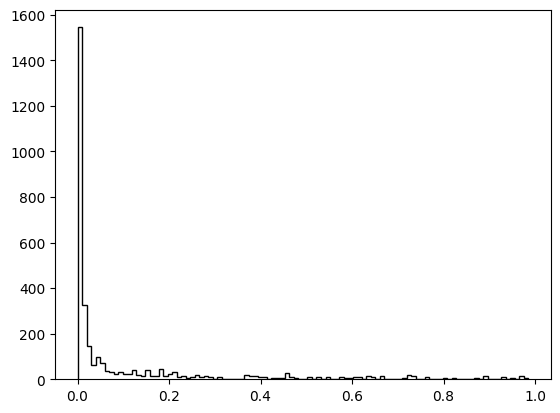

In [41]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")

(array([ 72., 111.,  32.,  39.,  33.,  12.,  27.,  15.,  49.,  27.,  53.,
          9.,  30.,  37.,   7.,  23.,  71.,  65.,  21.,  23.,  13.,   7.,
         25.,  22.,  46.,   8.,  24.,  21.,  22.,  39.,  12.,  11.,  69.,
         29.,  28.,  34.,  18.,  15.,  18.,  44.,  49.,  35.,   7.,  26.,
         63.,  48.,  50.,  28.,  40.,  15.,  18.,  35.,  39.,  60.,  18.,
         51.,  30.,  43.,  22.,  33.,  29.,  37.,  20.,  26.,  18.,  44.,
         52.,  26.,  52.,  57.,  35.,  35.,  65.,  35.,  51.,  97.,  91.,
         94.,  81.,  67.,  29.,  17.,   8.,  13.,   1.,  18.,  15.,  37.,
          5.,   7.,   0.,   0.,   9.,  16.,   6.,   4.,   8.,   0.,   0.,
         24.]),
 array([  0.41173904,   3.81471659,   7.21769414,  10.62067168,
         14.02364923,  17.42662678,  20.82960432,  24.23258187,
         27.63555941,  31.03853696,  34.44151451,  37.84449205,
         41.2474696 ,  44.65044715,  48.05342469,  51.45640224,
         54.85937979,  58.26235733,  61.66533488,  65.06831243

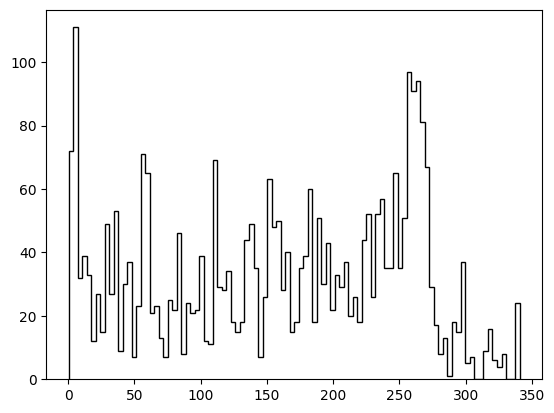

In [42]:
plt.hist(samples[:, 1], 100, color="k", histtype="step")

In [43]:
sampler.reset()
sampler.run_mcmc(state, 10000)

State([[ 5.02207152e-03  2.64142355e+02  4.82785606e+01]
 [ 5.00881140e-03  2.62843286e+02  4.81811518e+01]
 [ 5.00856719e-03  2.63994397e+02  4.81300368e+01]
 [ 5.02745304e-03  2.63076547e+02  4.67478191e+01]
 [ 4.91361759e-03  2.64348899e+02  4.85885482e+01]
 [ 4.99814911e-03  2.63463321e+02  4.84684233e+01]
 [ 5.03685688e-03  2.63537770e+02  4.85860074e+01]
 [ 4.96454927e-03  2.63212356e+02  4.73439526e+01]
 [ 5.01166146e-03  2.64481279e+02  4.70142706e+01]
 [ 5.01986063e-03  2.62891876e+02  4.96710344e+01]
 [ 4.95749413e-03  2.64082939e+02  4.84839351e+01]
 [ 5.08958361e-03  2.62501275e+02  4.88231111e+01]
 [ 4.96133450e-03  2.63990143e+02  4.77342547e+01]
 [ 5.08899432e-03  2.64078008e+02  4.82278363e+01]
 [ 4.93052587e-03  2.65137964e+02  4.75529791e+01]
 [ 4.94777518e-03  2.64664799e+02  4.69554627e+01]
 [ 5.06479123e-03  2.62708306e+02  4.80804421e+01]
 [ 5.00665975e-03  2.64152838e+02  4.79195207e+01]
 [ 5.00757712e-03  2.64163872e+02  4.72309459e+01]
 [ 4.98148670e-03  2.6400

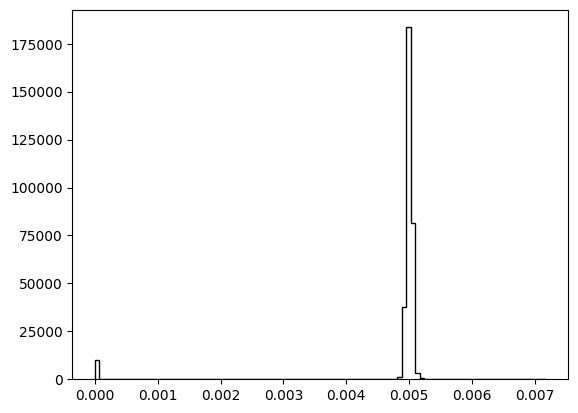

In [44]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.savefig('../plots/emcee_dip_g0p005.png',dpi=600)

In [45]:
np.savetxt('emcee_sample_dip_g0p005.txt',samples)

In [46]:
# samples = np.loadtxt('emcee_sample_dip_g0p005.txt')

In [47]:
samples[:,0]*=1e3

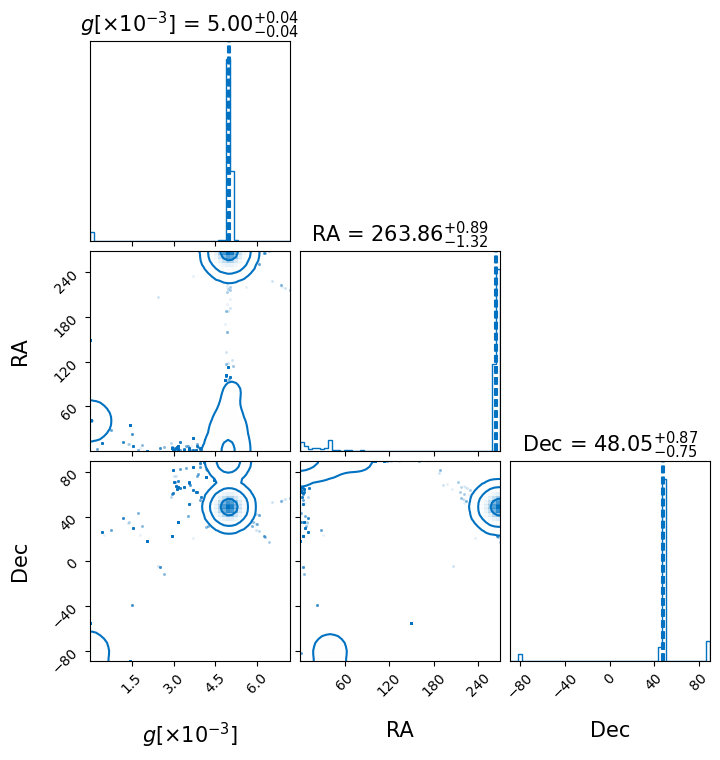

In [48]:
labels=[r'$g[\times 10^{-3}]$', 'RA', 'Dec']

fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p005_corner.pdf',bbox_inches='tight')

In [49]:
# samples = np.loadtxt('emcee_sample_dip_g0p005.txt')

In [50]:
sample_hist = np.histogram(samples[:,0],bins=500)

In [51]:
from scipy.integrate import simps
cdi = confidence_interval(sample_hist[0]/simps(sample_hist[0],sample_hist[1][:-1]), sample_hist[1][:-1])

/tmp/ipykernel_198187/3624433521.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  cdi = confidence_interval(sample_hist[0]/simps(sample_hist[0],sample_hist[1][:-1]), sample_hist[1][:-1])
/tmp/ipykernel_198187/1663745354.py:38: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdfvals = cumtrapz(self.posterior, self.param)


In [52]:
print(cdi.MAP(), cdi.upper_level-cdi.MAP(), cdi.MAP()-cdi.lower_level)

4.9823872384152725 0.05434046330846165 0.03309039316186624


In [24]:
def logprob_dl_g_H0(H0glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, Om0=0.3):
    H0 = H0glb[0]
    g = H0glb[1]
    l = H0glb[2]
    b = H0glb[3]

    if 0<=g<1 and 0<l<=360 and -90<=b<=90 and 10<H0<200:

        dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
        dipole_ICRS = dipole_gal.transform_to('icrs')

        phi_dipole = dipole_ICRS.ra.value*np.pi/180
        theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

        nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
        ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
        nz_dipole = np.cos(theta_dipole)

        chi2 = 0

        for i in range(len(ra_arr)):
            phi = ra_arr[i]
            theta = np.pi/2-np.array(dec_arr[i])

            nx = np.cos(phi)*np.sin(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(theta)

            dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

            astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
            zt = (1+zs_arr[i])/(1+dipole) -1
            dl_0 = astropy_cosmology.luminosity_distance(zt).value
            dl_g = dl_0*(1+dipole)

            chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2
        
        logprob = -0.5*chi2

    else:
        logprob = -np.inf

    return logprob

In [38]:
nwalkers = 32
ndim = 4
p0 = np.random.rand(nwalkers, ndim)*np.array([190,1,360,180]) - np.array([-10,0,0,90])
print(p0)

[[ 1.47840784e+02  6.71190202e-01  2.88354978e+02  8.01211202e+01]
 [ 1.29296304e+02  1.81669014e-01  2.97775834e+02 -5.47921190e+01]
 [ 9.78209388e+01  3.92516680e-01  3.43061703e+02 -8.92962384e+01]
 [ 9.31930412e+01  1.26139040e-01  2.45247521e+02 -6.00157338e+01]
 [ 1.10928266e+02  9.05744621e-01  2.95372574e+02 -3.28976942e+01]
 [ 9.83511921e+01  9.08319173e-01  1.38901791e+02  5.60233299e+01]
 [ 1.34659763e+02  7.94983117e-01  1.20468377e+02  7.19483218e+01]
 [ 1.99779331e+02  5.39714445e-01  1.99118950e+02 -8.84122511e+01]
 [ 3.77434795e+01  8.53253173e-01  1.50496537e+02  4.58413417e+01]
 [ 1.25659186e+02  1.78060973e-01  2.86350142e+02 -1.68838028e+01]
 [ 1.35960915e+02  7.96085506e-01  2.92306776e+02  8.42193666e+01]
 [ 5.16784907e+01  6.43915870e-01  2.15491711e+02  2.99093338e+01]
 [ 6.74591541e+01  5.25087610e-01  1.29079125e+02  9.19160637e-01]
 [ 1.25635502e+02  8.75062410e-02  2.39444381e+02  7.29628929e+01]
 [ 1.77969126e+02  9.82244402e-01  5.39596599e+01 -4.39002172e

In [39]:
logprob_dl_g_H0(p0[0], ra_mean, dec_mean, z0, dl_mean, dl_std)

-30084068.41619082

In [40]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_dl_g_H0, args=[ra_mean, dec_mean, z0, dl_mean, dl_std])


In [41]:
state = sampler.run_mcmc(p0, 100)


(array([  2.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,  12.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   6.,   6.,
          0.,   0.,   3.,   6.,   9.,  26.,  79., 368., 357., 371., 164.,
         92.,  76.,  75.,  77.,  27.,  74.,  23.,  37.,  34.,  44.,  16.,
         50.,  29.,  24.,  90.,  61.,  38.,  14.,  31.,  51.,  69.,  28.,
         75.,  37.,  43.,   6.,  59.,  22.,  15.,  15.,  33.,  29.,  18.,
         50.,  20.,  18.,  37.,  15.,  29.,   4.,   5.,  25.,  12.,   3.,
         21.,  11.,  16.,  11.,  19.,   5.,   0.,   4.,   2.,   1.,   8.,
         12.,   2.,   5.,   4.,   2.,   0.,   0.,   0.,  15.,   0.,   0.,
         16.]),
 array([ 14.81883197,  16.66843696,  18.51804195,  20.36764693,
         22.21725192,  24.0668569 ,  25.91646189,  27.76606687,
         29.61567186,  31.46527684,  33.31488183,  35.16448682,
         37.0140918 ,  38.86369679,  40.71330177,  42.56290676,
         44.41251174,  46.26211673,  48.11172172,  49.9613267 

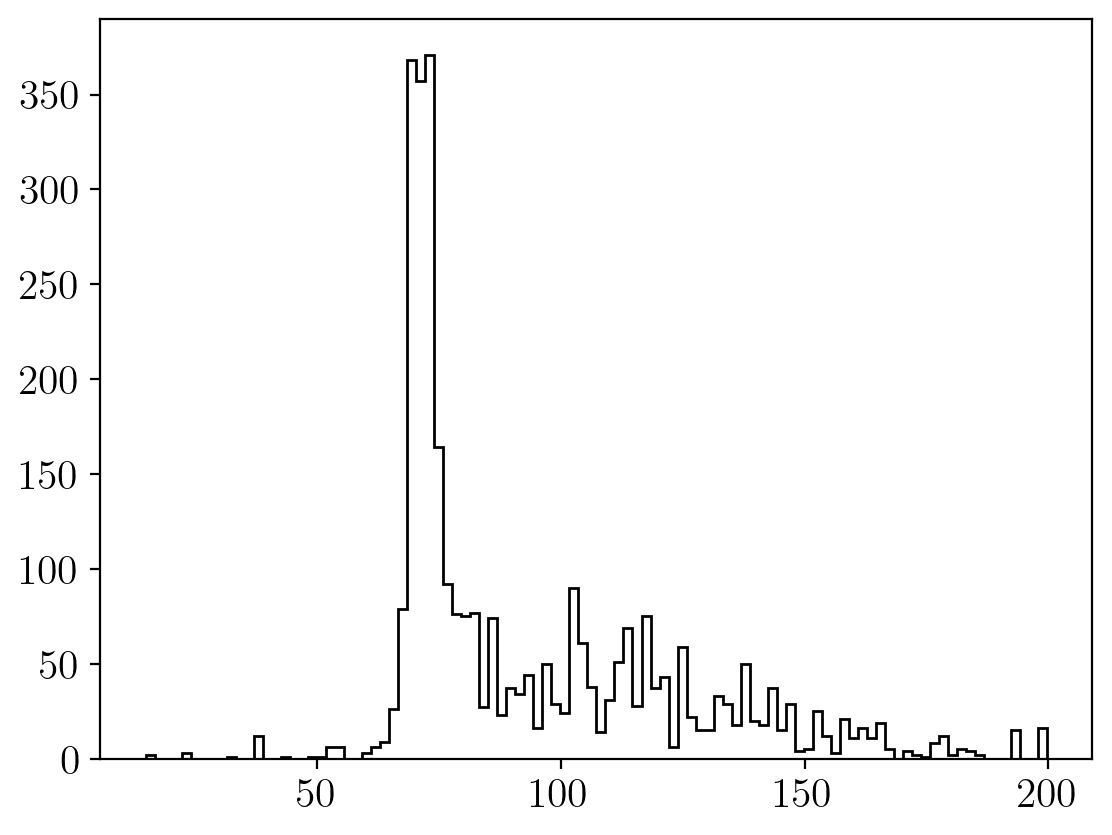

In [42]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")

In [43]:
sampler.reset()
sampler.run_mcmc(state, 10000)

State([[7.01181048e+01 4.93304679e-03 2.62085679e+02 4.88673111e+01]
 [6.99918765e+01 5.03664202e-03 2.63666895e+02 4.77453282e+01]
 [6.99708746e+01 4.98304464e-03 2.65611529e+02 4.76455102e+01]
 [7.00389413e+01 5.01367489e-03 2.64082086e+02 4.67643323e+01]
 [6.99710399e+01 4.93790912e-03 2.63148480e+02 4.74884020e+01]
 [7.00080949e+01 5.04698427e-03 2.65403724e+02 4.75479664e+01]
 [7.00017970e+01 5.01728807e-03 2.64608346e+02 4.81499542e+01]
 [6.98977108e+01 5.05484083e-03 2.63236039e+02 4.76491690e+01]
 [6.99703843e+01 4.97013116e-03 2.65774907e+02 4.78349688e+01]
 [7.00927664e+01 5.01558440e-03 2.62194604e+02 4.93997999e+01]
 [7.00382227e+01 4.92590561e-03 2.62324441e+02 4.75041163e+01]
 [7.00427755e+01 4.98729730e-03 2.63456286e+02 4.76626846e+01]
 [6.99743316e+01 5.01116702e-03 2.64697482e+02 4.77083594e+01]
 [6.99505745e+01 5.03395428e-03 2.65056901e+02 4.77588847e+01]
 [7.00234134e+01 5.02171578e-03 2.64103219e+02 4.86789754e+01]
 [6.99819183e+01 5.00409797e-03 2.64579682e+02 4.

Text(0, 0.5, 'Count')

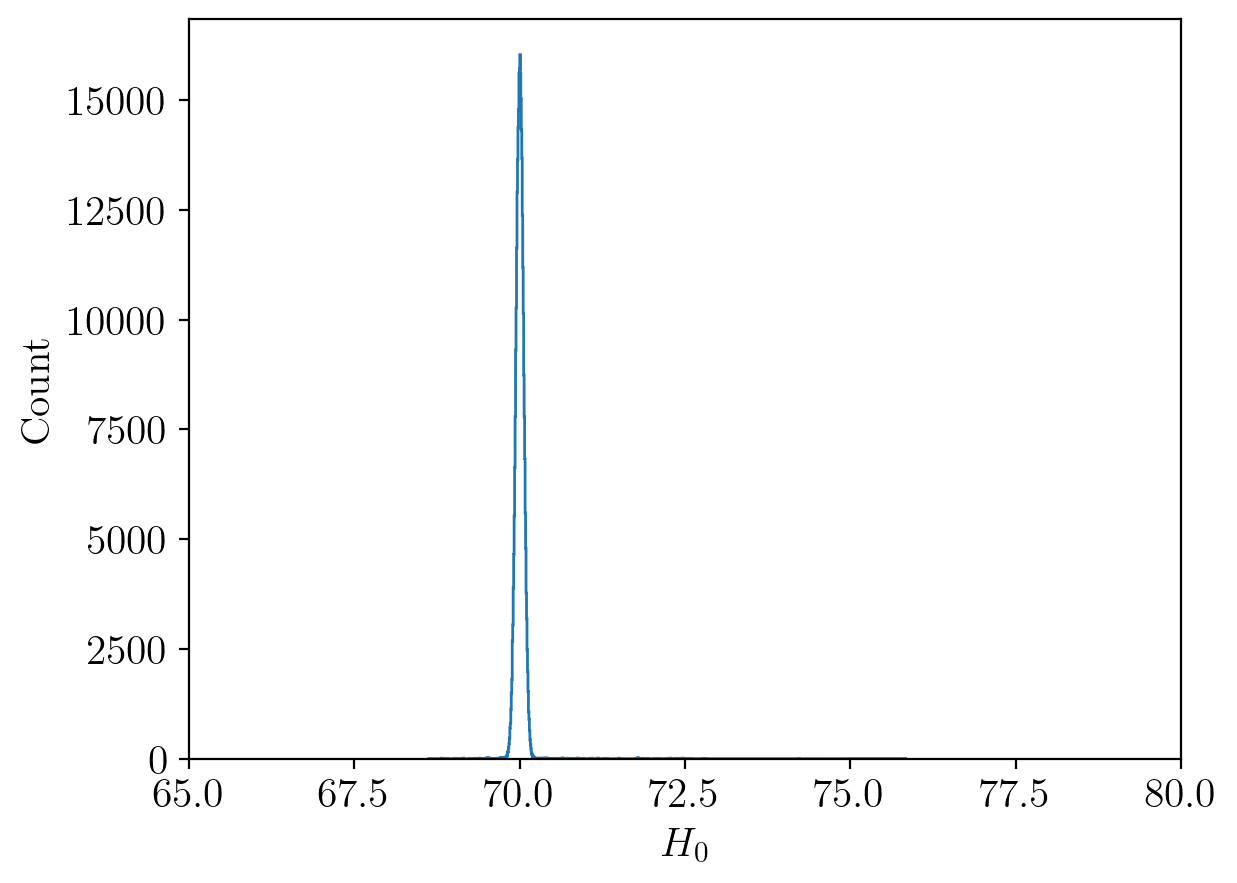

In [44]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 1000, histtype="step")
plt.xlim(65,80)
plt.xlabel(r'$H_0$')
plt.ylabel('Count')

In [45]:
np.savetxt('emcee_sample_dip_g0p005_H0.txt',samples)

In [46]:
samples[:,1]*=1e3

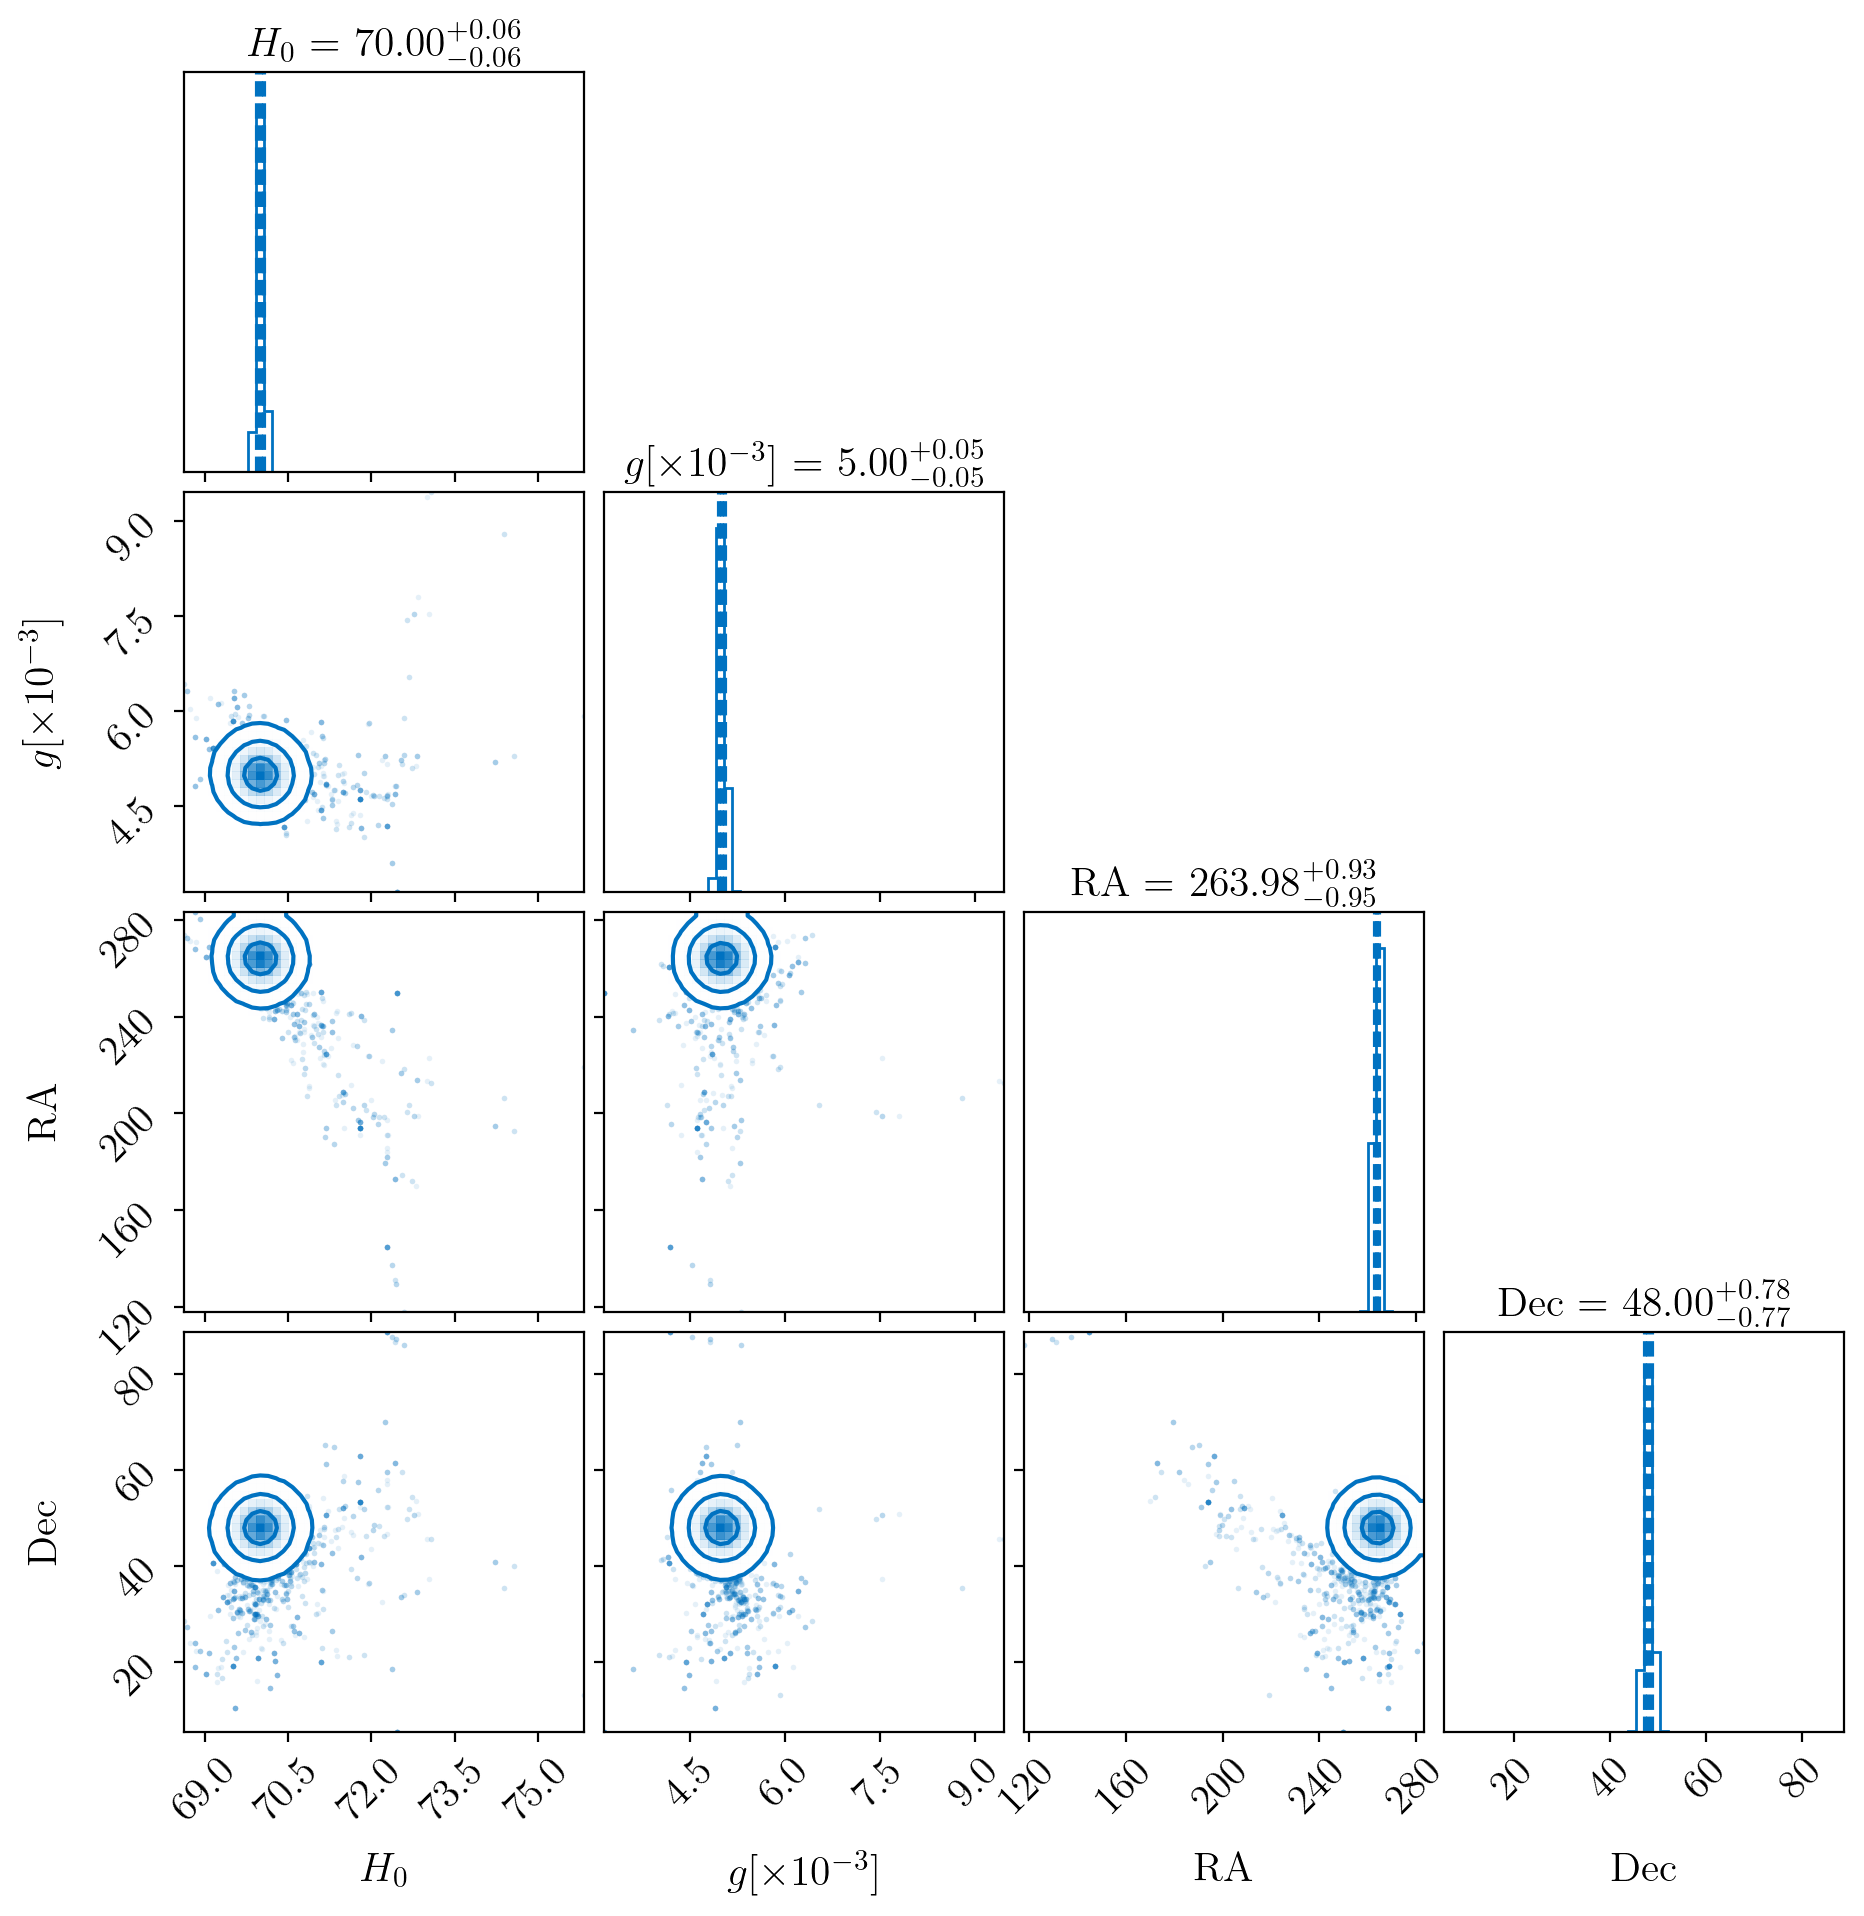

In [47]:
labels=[r'$H_0$',r'$g[\times 10^{-3}]$', 'RA', 'Dec']

fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p005_H0_corner.pdf',bbox_inches='tight')

In [48]:
Omega_m=0.3
Omega_Lambda=0.7

integrand = lambda zz: 1./np.sqrt(Omega_m*(1+zz)**3 + Omega_Lambda)

dlH0overc = []
for i in range(len(index_all)):
    zarr = np.linspace(0,z0[i],1000)
    dlH0overc.append((1+z0[i])*simps(integrand(zarr), zarr))

H0 = np.array(dlH0overc)* C_SI*1e-3 / np.array(dl_mean)


/tmp/ipykernel_247241/1784687697.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  dlH0overc.append((1+z0[i])*simps(integrand(zarr), zarr))


In [49]:
import astropy.coordinates as coord
import matplotlib as mpl
plt.rcParams.update({'font.size': 15})
mpl.rcParams['text.usetex'] = True

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def coordinates_aitoff_plot(coords,H0):
    fig, ax = plt.subplots(figsize=(10, 4), 
                           subplot_kw=dict(projection="aitoff"))
    # fig.subplots_adjust(bottom=0.2)

    sph = coords.spherical
    cs = ax.scatter(-sph.lon.wrap_at(180*u.deg).radian,
                    sph.lat.radian,marker='.',s=100,
                    c=H0,cmap='coolwarm')

    def fmt_func_x(x, pos):
        val = coord.Angle(-x*u.radian).wrap_at(360*u.deg).degree
        return f'${val:.0f}' + r'^{\circ}$'

    xticker = mpl.ticker.FuncFormatter(fmt_func_x)
    ax.xaxis.set_major_formatter(xticker)
    ax.xaxis.set_ticks([-np.pi*2/3,-np.pi/3,0,np.pi/3,np.pi*2/3])
    # ax.yaxis.set_ticks([-np.pi/3,-np.pi/6,0,np.pi/3,np.pi/6])

    ax.grid()
    
    cb = fig.colorbar(cs)
    cb.set_label(r'$H_0~[{\rm km}~{\rm s}^{-1}~{\rm Mpc}^{-1}]$')
    cb.set_ticks([min(H0),70,max(H0)])
    # plt.clim(-0.01,0.01)
    
    return fig, ax

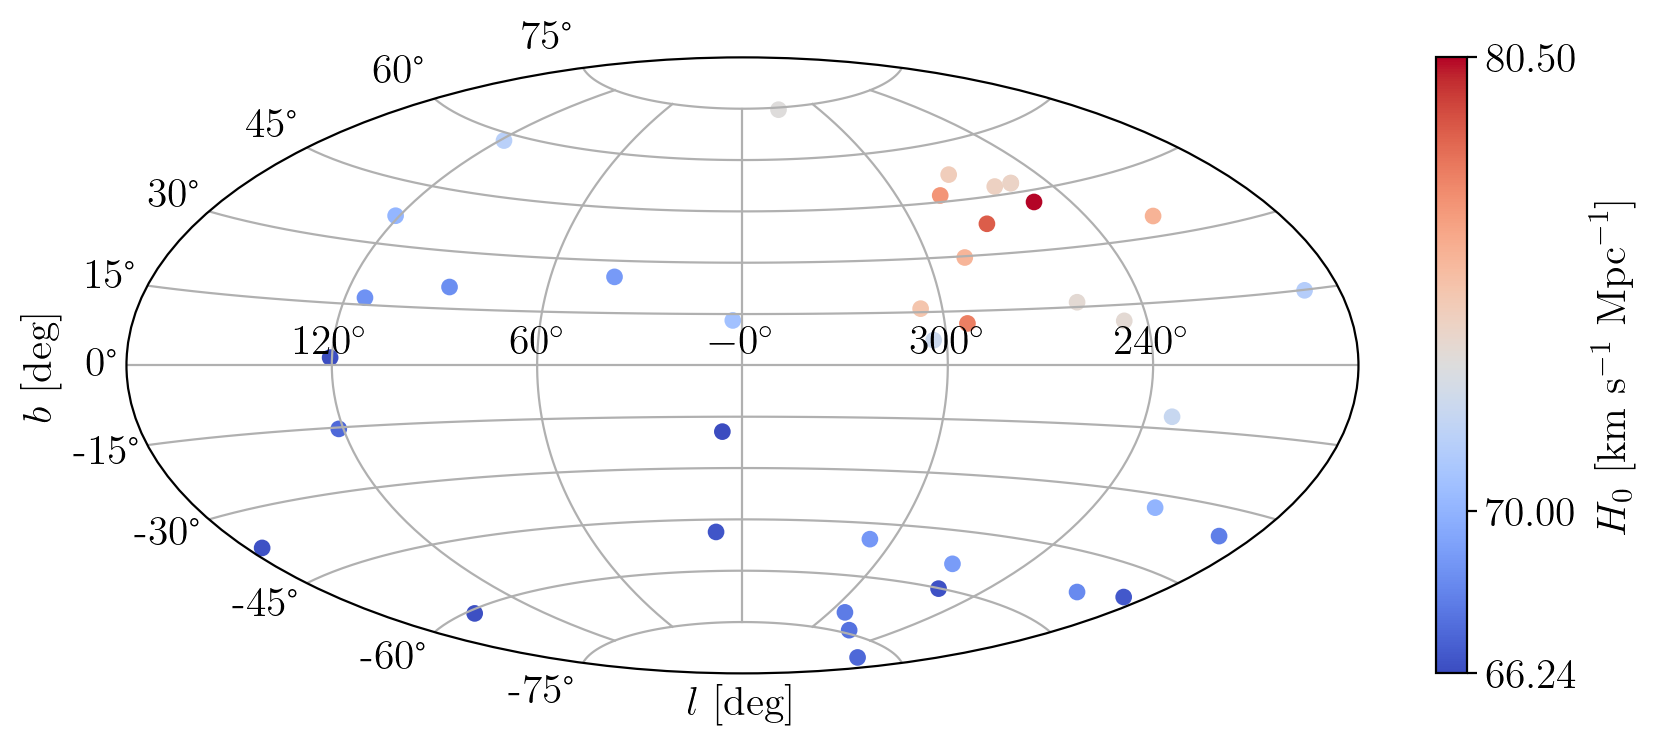

In [50]:
coord_golden = SkyCoord(ra_mean*u.radian, dec_mean*u.radian, frame='icrs')

fig, ax = coordinates_aitoff_plot(coord_golden.galactic,H0);
ax.set_xlabel('$l$ [deg]')
ax.set_ylabel('$b$ [deg]')
plt.savefig('../plots/H0_XG_golden_g0p005.png',dpi=600)